In [1]:
import numpy as np
import torch
import torchvision
import os
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
import os
import torchvision

Basic libraray were imported

Convert data in between 0 and 1 value using transform function.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
train_path='/content/drive/MyDrive/GurNum/train/'
val_path='/content/drive/MyDrive/GurNum/val'

load the dataset and than create batch of 64 for each train and validation set and shuffle them randomly,

In [5]:
trainset = torchvision.datasets.ImageFolder(train_path,transform=transform)
valset = torchvision.datasets.ImageFolder(val_path,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

some details of image

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


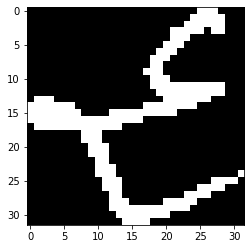

In [7]:
plt.imshow(images[0][1].numpy().squeeze(), cmap='gray_r')

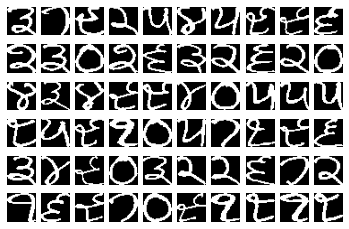

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index][0].numpy().squeeze(), cmap='gray_r')

Create neural network having input layer,output layer and number of hidden layer which can be vary to check the best perfromance of network.

In [9]:
input_size = 3072
hidden_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


In [21]:
criterion =nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Initialization of weight and than start updating in each iteration.

In [22]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 tensor([[-5.6884e-04, -6.4986e-04,  6.4860e-04,  ..., -4.8648e-04,
         -7.1248e-04, -7.1248e-04],
        [ 2.2941e-04,  4.5913e-04, -7.7427e-04,  ...,  3.2713e-04,
          2.5124e-04,  1.2240e-04],
        [ 2.6665e-05,  4.7522e-04, -7.0488e-04,  ...,  9.7014e-05,
          3.7140e-04,  2.3295e-04],
        ...,
        [ 2.0781e-04, -4.1166e-04, -5.6582e-04,  ...,  6.0166e-04,
          2.2908e-05,  2.2908e-05],
        [ 2.5649e-04,  2.5649e-04,  2.5649e-04,  ...,  2.0031e-04,
          2.5649e-04,  2.5649e-04],
        [ 2.8328e-04, -4.3674e-05, -1.9925e-04,  ...,  3.7421e-05,
         -1.0111e-04, -8.5005e-06]])
After backward pass: 
 tensor([[-2.9771e-04, -3.7874e-04,  9.0107e-04,  ..., -5.1157e-04,
         -7.8062e-04, -7.7752e-04],
        [ 9.5339e-05,  3.2506e-04, -8.8890e-04,  ...,  1.1707e-03,
          1.3863e-03,  2.9080e-04],
        [-6.6879e-04, -2.2024e-04, -1.3984e-03,  ...,  4.3002e-05,
          6.6358e-04,  1.1581e-04],
        ...,

Stochastic gradient descent is initialzie to train the model and update the weight of network to reduce the loss function. 

In [23]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: -0.7089946269989014
Epoch 1 - Training loss: -0.7297308221459389
Epoch 2 - Training loss: -0.7468818500638008
Epoch 3 - Training loss: -0.7597362361848354
Epoch 4 - Training loss: -0.7710200063884258
Epoch 5 - Training loss: -0.7879961505532265
Epoch 6 - Training loss: -0.8064373210072517
Epoch 7 - Training loss: -0.8280634470283985
Epoch 8 - Training loss: -0.8398306481540203
Epoch 9 - Training loss: -0.8487420529127121

Training Time (in minutes) = 0.31111690600713093


In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


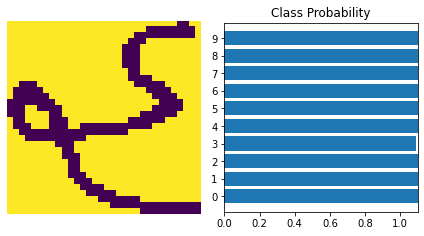

In [14]:
images, labels = next(iter(valloader))

img = images[0].view(1, 3072)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(3, 32, 32), ps)

In [24]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 3072)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 178

Model Accuracy = 0.848314606741573
